# A Markov Model for the Symmetric Configuration Model

This showcases the markov model created for the Bachelor's Thesis of Jannek Schaffert (jannek.schaffert@pluto.uni-freiburg.de). It was tested, however some edge-cases might exist where the code fails to deliver. Please notify me in such a case.

Python Kernel: base (Python 3.10.9)

In [28]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import sparse
from copy import deepcopy


sys.path.insert(0, '/home/schaffert/Documents/uni/physics_bsc/bachelorarbeit/DCM-main/DCM_markov')
import network as n
from evolve import evolve
import plot

%matplotlib inline


In [29]:
#Some useful functions for initializing the markov model
def equal_half_edges(nodes,half_edges_per_node):
    '''Create an array of half-edges with an equal amount per node'''
    half_edges = np.array([],dtype=int)
    for i in range(nodes):
        half_edges = np.append(half_edges,np.full(half_edges_per_node,i))
    return half_edges

def random_synapses(half_edges):
    '''create random synapses between the given half-edges'''
    edges = np.random.permutation(half_edges.size).reshape(int(half_edges.size/2),2)
    synapses  = np.zeros((half_edges.size,half_edges.size))
    for edge in edges:
        synapses[edge[0]][edge[1]] += 1
        synapses[edge[1]][edge[0]] += 1
    return synapses

def equal_adjacency_matrix(nodes,edge_count):
    '''Create synapses for a specified amount of nodes with equal edge count. 
    edge_count: MUST BE AN EVEN NUMBER. This is because the diagonal matrix entries must be even.'''

    #Create the half_edges for an edge count of 2
    half_edges = equal_half_edges(nodes,nodes*2)
    #add the same half-edges again until there are enough for the edge-count
    backup_half_edges = deepcopy(half_edges)
    for i in range(int(edge_count/2-1)):
        half_edges = np.append(half_edges,backup_half_edges)
    
    #create the edges for an edge count of 2
    edges = np.array([[0,0]])
    for i in range(nodes):
        for j in range(2*nodes-2*i-1):
            if j==0:
                edges = np.append(edges,np.array([[(i*nodes+i)*2,(i*nodes+i)*2+1]]),axis=0)
            else:
                if j%2==0:
                    #Do not ask what these indices are. They work so no liability is assumed for any changes. 
                    edges = np.append(edges,np.array([[(i*nodes+i)*2+j,2*(nodes)*(i+1)+nodes*(j-2)+2*i]]),axis=0)
                    edges = np.append(edges,np.array([[(i*nodes+i)*2+j+1,2*(nodes)*(i+1)+nodes*(j-2)+2*i+1]]),axis=0)
    edges = np.delete(edges,0,axis=0)
    
    #add the same edges for the rest of the half-edges
    backup_edges = deepcopy(edges)
    for i in range(int(edge_count/2)-1):
        edges = np.append(edges,backup_edges+((nodes*edge_count*2)*(i+1)),axis=0)

    #Create the actual synapses matrix
    synapses = np.zeros((half_edges.size,half_edges.size))
    for edge in edges:
        synapses[edge[0]][edge[1]] += 1
        synapses[edge[1]][edge[0]] += 1
    return half_edges, synapses, edges

def calculate_w(half_edges,synapses):
    '''Calculate the adjacency matrix for given half_edges and synapses. For testing purposes, not needed for the markov model'''
    w = np.zeros([np.max(half_edges), np.max(half_edges)],dtype = int)
    np.add.at(w, (half_edges[np.where(synapses==1)[0]],half_edges[np.where(synapses==1)[1]]), 1)
    return w

Testing the markov model with an empty graph and some free resources.

In [30]:
#parameters
nodes = 10
half_edges_per_node = 100

alpha = 0.5 # rate of edge creation
beta_noise = 0 # rate of random noise edge deletion. NOT PROPERLY INTEGRATED
h = 0.5 # step width


In [31]:
half_edges = equal_half_edges(nodes,half_edges_per_node)
synapses = np.zeros((half_edges.size,half_edges.size))

In [32]:
# Create a network object.
nw = n.Network(half_edges, synapses)

In [33]:
nw.half_edges

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [34]:
#An internal running index for all half-edges needed only in edge-creation
nw.heads_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [35]:
nw.synapses

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
#number of nodes
nw.n

10

In [37]:
#number of free edges
nw.z_hat

500.0

In [38]:
#adjacency matrix
nw.compute_w()
nw.w

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Now the simulation:

In [39]:
t_range = np.array([0, 15])

In [41]:
h = 3
evolve(nw, t_range, h, alpha, beta_noise, 'test_inst_pert_mcmc_sparse', 
       savemode='w')

Write simulation data to test_inst_pert_mcmc_sparse.hdf5
New time step from t_init= 0 to t_final = 15 .
DONE. Computation time: 0:00:00.149688


In [42]:
#Solution class for analyzing the evolution
sol = n.Solution('test_inst_pert_mcmc_sparse')

In [43]:
sol.filename

'test_inst_pert_mcmc_sparse'

Check if the initial condition loaded frm the output file agrees with the input.

In [44]:
np.all(sol.init_half_edges.toarray() == half_edges)

True

In [45]:
np.all(sol.init_synapses.toarray() == synapses)

True

In [46]:
sol.init_w

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
sol.init_z_hat

500.0

Compute the number of free edges over time.

In [48]:
# Up to a specific point in time, e.g. t=10 s.
z_hat_until10 = sol.z_hat_t(t_fin=10)

Nearest time point found: 9.0


In [49]:
# For the whole simulation.
z_hat_t = sol.z_hat_t(end=True)

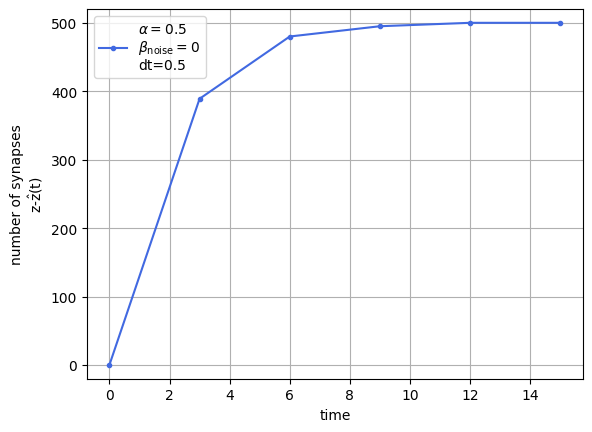

In [50]:
plt.figure()
plt.plot(sol.time, nw.z - z_hat_t, '.-', c='royalblue', 
         label=r'$\alpha=0.5$' + '\n' + r'$\beta_{\rm noise}=0$' + '\ndt=0.5')
plt.xlabel('time')
plt.ylabel('number of synapses\n' + r'z-$\hat{\rm z}$(t)')
plt.ylim([-20,520])
plt.grid()
plt.legend()
plt.show()

Nearest time point found: 15.0


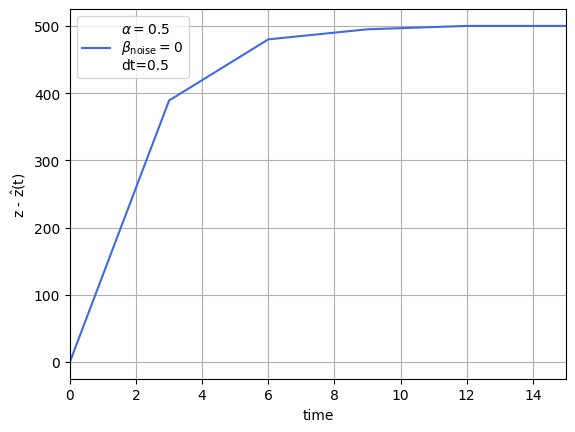

In [51]:
# Same with function from plot module.
plot.plot_bound([sol], labels=[r'$\alpha=0.5$' + '\n' + r'$\beta_{\rm noise}=0$' + '\ndt=0.5'])

In [52]:
# Get the adjacency matrix at t=[1, 4, 15] s.
w_1 = sol.w(t=1)
w_4 = sol.w(t=4)
w_fin = sol.w(end=True)

Nearest time point found: 0.0
Nearest time point found: 3.0


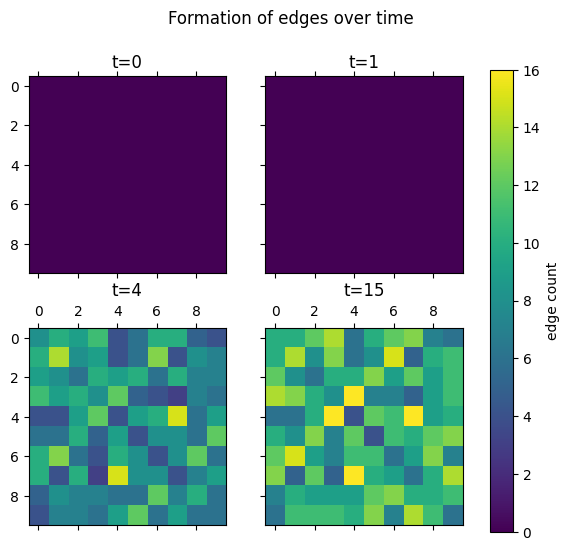

In [53]:
# Plot the adjacency matrix at t=[0, 1, 4, 15] s.
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[7,6], sharex=True, sharey=True)

mat = axs[0][0].matshow(sol.init_w, cmap='viridis', vmin=0, vmax=16)
axs[0][1].matshow(w_1, cmap='viridis', vmin=0, vmax=16)
axs[1][0].matshow(w_4, cmap='viridis', vmin=0, vmax=16)
axs[1][1].matshow(w_fin, cmap='viridis', vmin=0, vmax=16)

axs[0][0].set_title("t=0")
axs[0][1].set_title("t=1")
axs[1][0].set_title("t=4")
axs[1][1].set_title("t=15")
fig.suptitle(r"Formation of edges over time")

cbar=fig.colorbar(mat, ax=axs)
cbar.set_label('edge count')
plt.show()

Nearest time point found: 0.0
Nearest time point found: 0.0
Nearest time point found: 3.0
Nearest time point found: 15.0


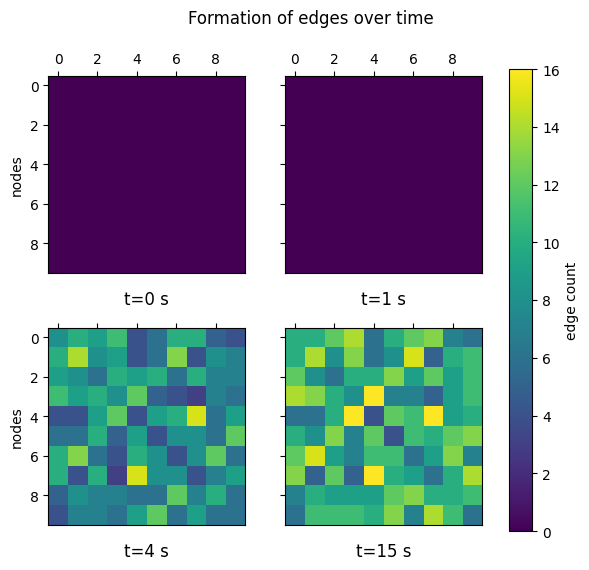

In [54]:
# Same with function from plot module.
plot.plot_w([sol], np.array([0, 1, 4, 15]), nrows=2, ncols=2, figsize=[7, 6], logscale=False, 
            subtitles=["t=0 s", "t=1 s", "t=4 s", "t=15 s"], 
            title=r"Formation of edges over time")

Introducing a perturbation of edges to a fully connected graph

In [27]:
edge_count = 10

In [28]:
half_edges2, synapses2, edges2 = equal_adjacency_matrix(nodes,edge_count)

In [29]:
nw2 = n.Network(half_edges2, synapses2)

In [30]:
t_range = np.array([0, 15])

In [31]:
# Apply one instant perturbation at t=5.
edge_pert_times = np.array([5])
# Delete 4 edge connecting node 2 and 4.
edge_perts = [{'epsilon': np.array([4]), 'pattern': np.array([[2,4]])}]

In [32]:
evolve(nw2, t_range, h, alpha, beta_noise, 'test_edge_pert_mcmc', 
       savemode='w',
       edge_perts=edge_perts, edge_pert_times=edge_pert_times)

Write simulation data to test_edge_pert_mcmc.hdf5
New time step from t_init= 0 to t_final = 5 .


New time step from t_init= 5 to t_final = 15 .
Instantaneous perturbation of the configuration! Deleting $\epsilon$ = [4] random edges coming between the following nodes:  [[2 4]] .
DONE. Computation time: 0:00:00.783625


In [33]:
sol2 = n.Solution('test_edge_pert_mcmc')

Nearest time point found: 15.0


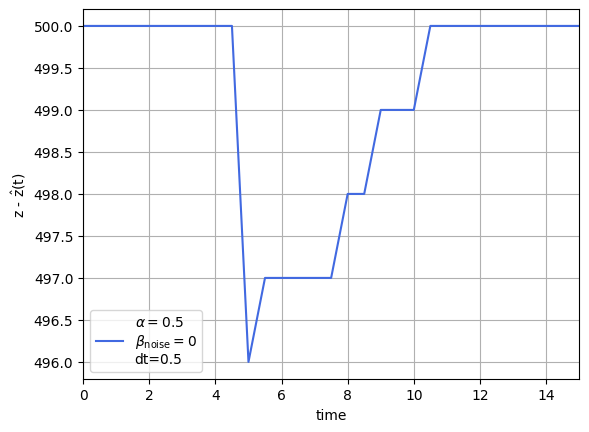

In [34]:
plot.plot_bound([sol2], labels=[r'$\alpha=0.5$' + '\n' + r'$\beta_{\rm noise}=0$' + '\ndt=0.5'])

Nearest time point found: 0.0
Nearest time point found: 5.0
Nearest time point found: 7.0
Nearest time point found: 15.0


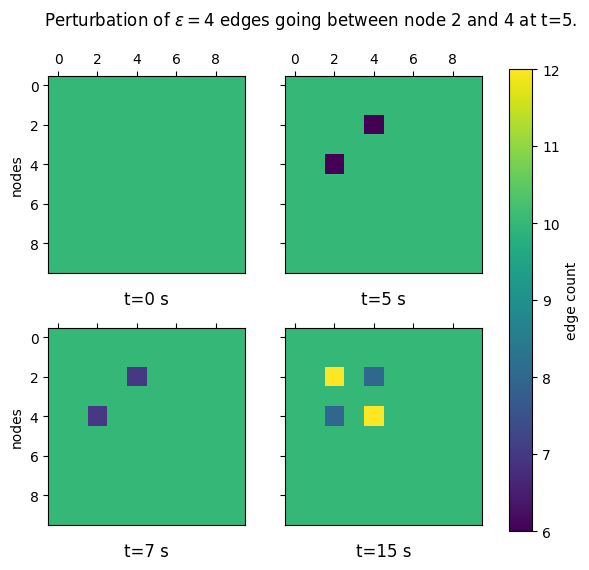

In [35]:
plot.plot_w([sol2], np.array([0, 5, 7, 15]), nrows=2, ncols=2, figsize=[7, 6], logscale=False, 
            subtitles=["t=0 s", "t=5 s", "t=7 s", "t=15 s"], 
            title=r"Perturbation of $\epsilon=4$ edges going between node 2 and 4 at t=5.")

Introducing a perturbation of nodes to a fully connected graph

In [84]:
half_edges3, synapses3, edges3 = equal_adjacency_matrix(nodes,edge_count)

In [38]:
nw3 = n.Network(half_edges3, synapses3)

In [39]:
t_range = np.array([0, 15])

In [40]:
# Apply one instant perturbation at t=5.
inst_pert_times = np.array([5])
# Delete 10 edges emanating from and/or pointing towards nodes [1, 3].
inst_perts = [{'epsilon': np.array([100]), 'pattern': np.array([1, 3])}]

In [41]:
evolve(nw3, t_range, h, alpha, beta_noise, 'test_inst_pert_mcmc', 
       savemode='w',
       inst_perts=inst_perts, inst_pert_times=inst_pert_times)

Write simulation data to test_inst_pert_mcmc.hdf5
New time step from t_init= 0.0 to t_final = 5.0 .


New time step from t_init= 5.0 to t_final = 15.0 .
Instantaneous perturbation of the configuration! Deleting $\epsilon$ = [100] random edges coming from and/or going to a node in the pattern [1 3] .
DONE. Computation time: 0:00:00.788870


In [42]:
sol3 = n.Solution('test_inst_pert_mcmc')

Nearest time point found: 15.0


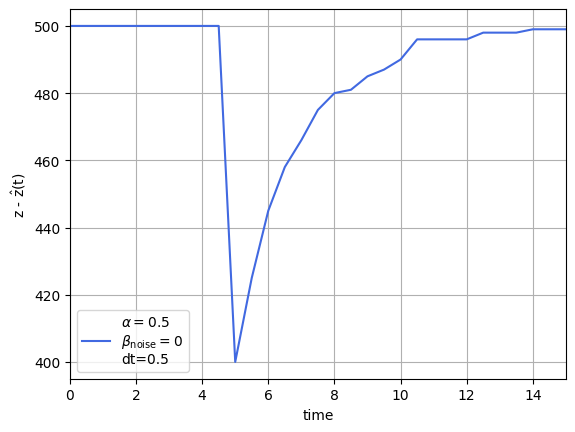

In [43]:
plot.plot_bound([sol3], labels=[r'$\alpha=0.5$' + '\n' + r'$\beta_{\rm noise}=0$' + '\ndt=0.5'])

Nearest time point found: 0.0
Nearest time point found: 5.0
Nearest time point found: 7.0
Nearest time point found: 15.0


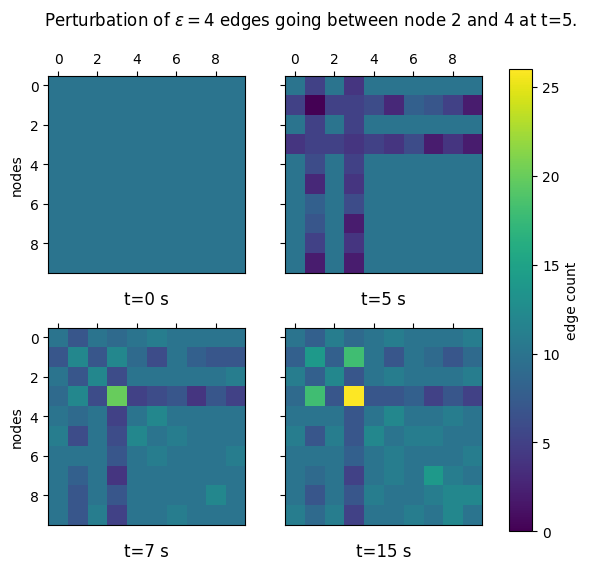

In [44]:
plot.plot_w([sol3], np.array([0, 5, 7, 15]), nrows=2, ncols=2, figsize=[7, 6], logscale=False, 
            subtitles=["t=0 s", "t=5 s", "t=7 s", "t=15 s"], 
            title=r"Perturbation of $\epsilon=4$ edges going between node 2 and 4 at t=5.")

Averaging over multiple runs

In [78]:
def multi_evolve(network, t_range, h, alpha, beta_noise, filename, repeats, savemode):
    w_cum = np.zeros((1,network.n,network.n))
    for i in range(repeats):
        network_i = deepcopy(network)
        evolve(network_i, t_range, h, alpha, beta_noise, filename, savemode=savemode, verbose=False)
        sol_i = n.Solution(filename)
        #print(sol_i.w(end=True))
        w_cum = np.append(w_cum,np.array([sol_i.w(end=True)]),axis=0)
    w_cum = np.delete(w_cum,0,axis=0)
    return w_cum

In [86]:
half_edges4 = equal_half_edges(nodes,half_edges_per_node)
synapses4 = np.zeros((half_edges.size,half_edges.size))

In [87]:
nw4 = n.Network(half_edges4, synapses4)

In [88]:
t_range = np.array([0, 15])
repeats = 5
filename = "/home/schaffert/Documents/uni/physics_bsc/bachelorarbeit/DCM-main/DCM_markov/test"

In [98]:
w_gesamt = multi_evolve(nw4, t_range, h, alpha, beta_noise, filename, repeats, 'w')

DONE. Computation time: 0:00:00.782062
DONE. Computation time: 0:00:00.736840
DONE. Computation time: 0:00:00.722107
DONE. Computation time: 0:00:00.748313
DONE. Computation time: 0:00:00.698780


In [99]:
w_durch = np.sum(w_gesamt,axis=0)/repeats
w_durch

array([[ 5.2, 13. , 10.2,  9.4,  9.4, 10.6,  9.4, 10.6, 13.4,  8.8],
       [13. , 11.2, 10.2,  8.8,  7.8,  9. , 11.2, 10.2,  8.8,  9.6],
       [10.2, 10.2, 10.4,  8.8, 11.4,  9.2, 10.8, 11.2,  8. ,  9.8],
       [ 9.4,  8.8,  8.8, 10. ,  8.8, 10.4, 11. , 11.4, 10.8, 10.4],
       [ 9.4,  7.8, 11.4,  8.8, 10. , 10.2, 12.8,  9.8,  9.8,  9.8],
       [10.6,  9. ,  9.2, 10.4, 10.2, 10.4,  9.8, 10.8,  9.6, 10. ],
       [ 9.4, 11.2, 10.8, 11. , 12.8,  9.8,  7.6,  8.8,  7.6, 11. ],
       [10.6, 10.2, 11.2, 11.4,  9.8, 10.8,  8.8,  9.2,  8.8,  9.2],
       [13.4,  8.8,  8. , 10.8,  9.8,  9.6,  7.6,  8.8, 12.4, 10.8],
       [ 8.8,  9.6,  9.8, 10.4,  9.8, 10. , 11. ,  9.2, 10.8, 10.4]])

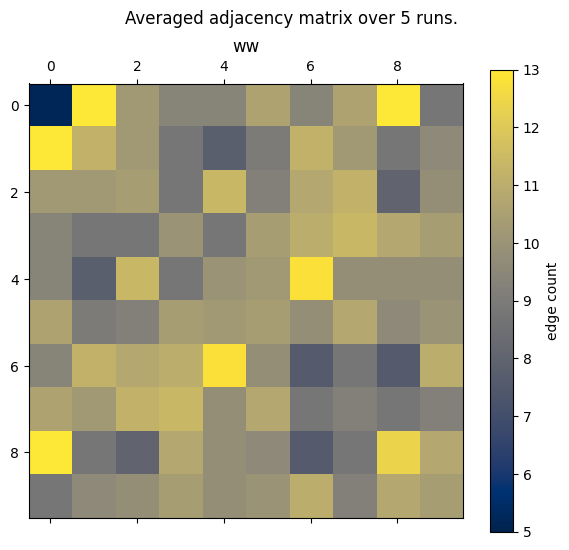

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[7,6], sharex=True, sharey=True)

mat = axs.matshow(w_durch, cmap='cividis', vmin=5, vmax=13)

axs.set_title("ww")
fig.suptitle(r"Averaged adjacency matrix over "+ str(repeats) + r" runs.")

cbar=fig.colorbar(mat, ax=axs)
cbar.set_label('edge count')
plt.show()